In [64]:
import numpy as np
import pandas as pd
import math
import csv 

import torch
import torch.nn as nn
from torch.autograd import Variable as V
from torch.utils.data import DataLoader,Dataset,TensorDataset
 
import matplotlib.pyplot as plt          

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from tqdm import tqdm

x-data

In [6]:
data_train = np.load('data/train.npy', allow_pickle=True)
data_test = np.load('data/test.npy', allow_pickle=True)

In [7]:
data_train = np.delete(data_train, -1, axis=1)
data_test = np.delete(data_test, -1, axis=1)

y-data

In [8]:
y_test = np.load('data/y_test.npy', allow_pickle=True)
y_train = np.load('data/y_train.npy', allow_pickle=True)

In [9]:
n,m = y_test.shape
for i in range(n):
    if y_test[i][0] == 'normal.':
        y_test[i][0] = int(1)
    else:
        y_test[i][0] = int(0)
    
n,m = y_train.shape
for i in range(n):
    if y_train[i][0] == 'normal.':
        y_train[i][0] = int(1)
    else:
        y_train[i][0] = int(0)


data-loader

In [16]:
def data_loader(x, y):
    MMScaler = MinMaxScaler()
    x = MMScaler.fit_transform(x)
    tensor_x = torch.from_numpy(x.astype(np.float32))
    tensor_y = torch.from_numpy(y.astype(np.float32))

    dataset = TensorDataset(tensor_x, tensor_y)
    dataset_loader = DataLoader(dataset, batch_size=4096, shuffle=False)
    return dataset_loader

In [63]:
dataloader = data_loader(data_train, y_train)
testdata_loader = data_loader(data_test, y_test)

build network

In [120]:
class network(nn.Module):                    
    def __init__(self, init_op, motivate_op):                         
        super(network,self).__init__() 
        # 激活函数
        if motivate_op == 1:     # sigmoid
            self.func = nn.Sigmoid()
        elif motivate_op == 2:   # Tanh
            self.func = nn.Tanh()
        elif motivate_op == 3:   # LeakyReLU
            self.func = nn.LeakyReLU()

        self.encoder = nn.Sequential(         
            nn.Linear(41, 24),                    
            self.func,                      
            nn.Linear(24, 16),       
            self.func,                         
            nn.Linear(16, 8),   
            self.func,                             
            nn.Linear(8, 4),
            self.func,                          
            nn.Linear(4, 1), 
            nn.Sigmoid()
        )                     

        # 初始化参数
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_op == 1:
                # remain zero!
                    print(m)
                elif init_op == 2:
                    nn.init.xavier_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)  
                                               
    def forward(self, x):                       
        encoder = self.encoder(x)                 
        return encoder                                                        

In [113]:
def train(model, criterion, optimizer, dataset_loader, epoch_num = 300):
    train_loss_list = []
    for epoch in range(epoch_num):
        total_loss = 0
        for i ,(x,y) in enumerate(tqdm(dataset_loader)):
            pred = model(V(x))
            # print(pred, y)
            # loss = criterion(pred, y)
            loss = criterion(pred, y.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss
        train_loss_list.append(total_loss)
        # print("epoch: ", total_loss)
        if epoch % 10 == 0:
            print(epoch, ":", total_loss.data.numpy())
    return model, train_loss_list

In [146]:
def test(model, criterion, dataset_loader):
    total_loss = 0
    for i ,(x,y) in enumerate(tqdm(dataset_loader)):
        pred = model(V(x))
        loss = criterion(pred, y)
        total_loss += loss
    return total_loss

In [83]:
def init(init_op, motivate_op, optimizer_op):
    model = network(init_op, motivate_op)

    # 计算loss
    criterion = nn.BCELoss()
    
    if optimizer_op == 1: # Adam
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    elif optimizer_op == 2: # SGD
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
    
    return model, criterion, optimizer

In [124]:
def draw(data):
    n = len(data)
    x = []
    y = []
    for i in range(n):
        y.append(torch.detach(data[i]))
        x.append(i+1)
        
    plt.plot(np.array(x), np.array(y), c='yellow')   
    plt.show()

In [105]:
def run(epoch, init_op, motivate_op, optimizer_op):
    model, criterion, optimizer = init(init_op, motivate_op, optimizer_op)
    model, train_error_list = train(model, criterion, optimizer, dataloader, epoch)
    return model, train_error_list

In [ ]:
# init_op:
# 1: remain zero
# 2: normal

# motivate_op:
# 1: sigmoid
# 2: tanh
# 3: leakyRelu

# optimizer_op:
# 1: Adam
# 2: SGD

In [ ]:
# zero, tanh, SGD 
model, train_error = run(epoch=60, init_op = 1, motivate_op = 2, optimizer_op = 2)

In [ ]:
# normal, sigmoid, Adam
model1, train_error1 = run(epoch=60, init_op = 2, motivate_op = 1, optimizer_op = 1)

In [ ]:
# normal, leakyRelu, SGD
model2, train_error2 = run(epoch=60, init_op = 2, motivate_op = 3, optimizer_op = 1)

In [ ]:
# zero, leakyRelu, SGD
model3, train_error3 = run(epoch=60, init_op = 1, motivate_op = 2, optimizer_op = 2)

In [ ]:
draw(train_error)
draw(train_error1)
draw(train_error2)
draw(train_error3)

In [143]:
def draw2(data_list, label_list):
    cnt = 0
    for data in data_list:
        n = len(data)
        x = []
        y = []
        for i in range(n):
            y.append(torch.detach(data[i]))
            x.append(i+1)
            
        plt.plot(np.array(x), np.array(y), '*-', label = label_list[cnt])
        cnt += 1   
    plt.legend() 
    plt.show()

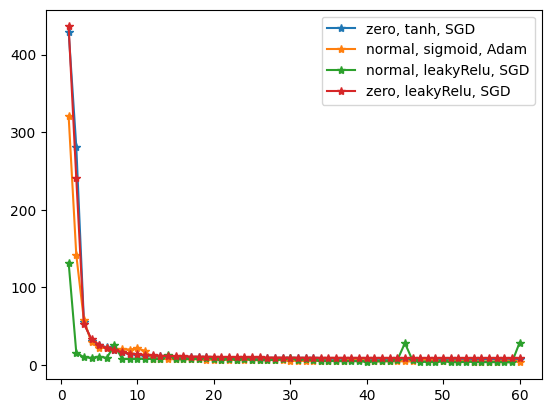

In [144]:
draw2([train_error, train_error1, train_error2, train_error3], 
    ["zero, tanh, SGD", "normal, sigmoid, Adam", "normal, leakyRelu, SGD", "zero, leakyRelu, SGD"])

In [151]:
test_error = test(model, nn.BCELoss(), testdata_loader)
print("zero, tanh, SGD - test_error: ", test_error)

100%|██████████| 239/239 [00:06<00:00, 39.08it/s]

zero, tanh, SGD - test_error:  tensor(1.8414, grad_fn=<AddBackward0>)


In [152]:
test_error = test(model1, nn.BCELoss(), testdata_loader)
print("normal, sigmoid, Adam - test_error: ", test_error)

100%|██████████| 239/239 [00:06<00:00, 37.20it/s]

normal, sigmoid, Adam - test_error:  tensor(1.0567, grad_fn=<AddBackward0>)


In [153]:
test_error = test(model2, nn.BCELoss(), testdata_loader)
print("normal, leakyRelu, SGD - test_error: ", test_error)

100%|██████████| 239/239 [00:06<00:00, 36.98it/s]

normal, leakyRelu, SGD - test_error:  tensor(1.8335, grad_fn=<AddBackward0>)


In [154]:
test_error = test(model3, nn.BCELoss(), testdata_loader)
print("zero, leakyRelu, SGD - test_error: ", test_error)

100%|██████████| 239/239 [00:06<00:00, 37.51it/s]

zero, leakyRelu, SGD - test_error:  tensor(2.0763, grad_fn=<AddBackward0>)
